# AE 667 - Assignment 2

# Blade Element Momentum Theory Implementation Tool

## User Manual:
Run each segment of the code by pressing Shift+Enter in order. The initial part asks for the user input for the various blade parameters and gives the values of C_T and C_Q based on this input. Later a validation is shown to justify that the code gives reasonable values. The user may need to change the input parameters as specified to run the validation part. For any other blade, the code will directly provide the C_T and C_Q values and also a plot showing their variation with root pitch angle.

In [17]:
# pre-requisites - python packages

%matplotlib inline
import numpy as np
from math import *
import matplotlib
from matplotlib import pyplot as plt
import scipy.integrate as i
from ipywidgets import interact, IntSlider, FloatSlider

In [2]:
# density variation with altitude
def density (h):
    rho0 = 1.225
    lapse = 0.0065
    T0 = 288.15
    g = 9.81
    R = 287.1
    rho = rho0*(1-lapse*h/T0)**((g/lapse/R)-1)
    return rho

## User Inputs:
The user has to input the following rotor/propeller specifications to determine its performance parameters.

In [12]:
h = float(input("Enter the operation altitude of the drone (m) : "))
rho = density(h)

Enter the operation altitude of the drone (m) : 0


The linear twist is assumed of the form theta = E + tw*r, where 'E' and 'tw' define the nature of the twist. 'E' is the angle of attack in degrees at the point on the blade nearest to the axis, i.e. root cut-out and 'tw' is the rate of twist for the blade in deg/metre. 'r' is the distance from the axis of rotation measured in metres. The values of 'E' and 'tw' will be the user input.

In [21]:
# User should enter the values as per the geomentry of the rotor/propeller which needs to be analyzed.

E = float(input("Enter the root pitch (deg) : "))
tw = float(input("Enter the twist rate (deg/m) : "))

Enter the root pitch (deg) : 2
Enter the twist rate (deg/m) : 0


The linear taper is assumed to be c = G + Hr, where 'G' and 'H' define the nature of the taper. 'G' is the chord length at the point on the blade nearest to the axis in metres and 'H' is the rate of taper for the blade.

In [6]:
# User should enter the values as per the geomentry of the rotor/propeller which needs to be analyzed.

G = float(input("Enter the root chord (m) : "))
H = float(input("Enter the taper rate : "))

Enter the root chord (m) : 0.0508
Enter the taper rate : 0


In [8]:
# Enter the root cut-out length, the length of one blade of the rotor/propeller in metres and 
#the number of blades for one rotor/propeller.

r_RC = float(input("Enter the root cut-out length (m) : "))
L = float(input("Enter the length of the blade (m) : "))
b = int(input("Enter the number of blades : "))
R = r_RC + L            #this R will be the radius of the disk formed by the rotor/propeller

Enter the root cut-out length (m) : 0.125
Enter the length of the blade (m) : 0.637
Enter the number of blades : 2


The Lift coefficient is taken to be linearly varying with the angle of attack, i.e. Cl = a * alpha.
The relation for the drag coefficient Cd is taken as Cd = Cd0 + k * alpha^2 

In [10]:
# Enter the slope of the lift coefficient curve-

a = float(input("Enter lift curve slope (rad^(-1)) : "))

# Enter Cd0 and k values for the drag coefficient variation-

Cd0 = float(input("Enter profile drag coefficient : "))
k = float(input("Enter the value of k (rad^(-2)) : "))

Enter lift curve slope (rad^(-1)) : 5.75
Enter profile drag coefficient : 0.0113
Enter the value of k (rad^(-2)) : 1.25


In [11]:
# Enter the flight velocity V of the drone in m/s and the rotation speed of the rotor/propeller in rpm.

V = float(input("Enter the flight velocity (m/s) : "))
omega = float(input("Enter the RPM of the blades : "))*2*pi/60

Enter the flight velocity (m/s) : 0
Enter the RPM of the blades : 960


## Function definitions
Now we define the python functions which will be used in the computation of the performance parameters.

In [22]:
# these functions are defined based on the theory described in the report. These functions take multiple parameters
#as input for more flexibility over the results obtained

def theta (r, E, tw):
    theta = E + tw*r
    return theta*pi/180

def chord (r, G, H):
    c = G + H*r
    return c

def solidity (r, b, G, H):
    sigma = b*chord(r, G, H) / (pi*R)
    return sigma

def inflow (r, E, b, n, G, H, tw):
    lambda_c = V / (omega*R)
    flow = sqrt((solidity(r, b, G, H)*a/16-lambda_c/2)**2 + solidity(r, b, G, H)*a/8*theta(r, E, tw)*r/R) - (solidity(r, b, G, H)*a/16-lambda_c/2)
    if n == 0:
        return flow
    
    for c in range(10):
        f = b/2*(1-r/R)/flow
        F = 2/pi*acos(exp(-f))
        lamb = sqrt((solidity(r, b, G, H)*a/16/F-lambda_c/2)**2 + solidity(r, b, G, H)*a/8/F*theta(r, E, tw)*r/R) - (solidity(r, b, G, H)*a/16/F-lambda_c/2)
        flow = lamb  
    return flow

def phi (r, E, b, n, G, H, tw):
    phi = inflow(r, E, b, n, G, H, tw)*R/r
    return atan(phi)

def Cl (r, E, b, n, G, H, tw):
    alpha = theta(r, E, tw) - phi(r, E, b, n, G, H, tw)
    return a*alpha

def Cd (r, E, b, n, G, H, tw):
    alpha = theta(r, E, tw) - phi(r, E, b, n, G, H, tw)
    Cd = Cd0 + k*alpha**2
    return Cd

def velocity (r, E, b, n, G, H, tw):
    U_t = omega*r
    U_p = inflow(r, E, b, n, G, H, tw)*omega*R
    return sqrt(U_t**2 + U_p**2)

def dT (r, E, b, n, G, H, tw):
    dT = b*0.5*rho*velocity(r, E, b, n, G, H, tw)**2*chord(r, G, H)*(Cl(r, E, b, n, G, H, tw)*cos(phi(r, E, b, n, G, H, tw)) - Cd(r, E, b, n, G, H, tw)*sin(phi(r, E, b, n, G, H, tw)))
    return dT

def dQ (r, E, b, n, G, H, tw):
    dQ = b*r*0.5*rho*velocity(r, E, b, n, G, H, tw)**2*chord(r, G, H)*(Cd(r, E, b, n, G, H, tw)*cos(phi(r, E, b, n, G, H, tw)) + Cl(r, E, b, n, G, H, tw)*sin(phi(r, E, b, n, G, H, tw)))
    return dQ

## Performance analysis plots

Thrust coefficient without considering tip losses = 0.0009884468538853193
Thrust coefficient considering tip losses = 0.0009601694547727534
Torque coefficient without considering tip losses = 0.00013906686569135305
Torque coefficient considering tip losses = 0.00013861228628929607


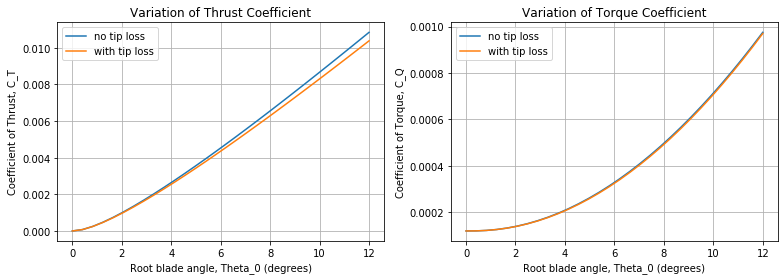

In [23]:
# here we find the value of the C_T and C_Q based on the given input parameters.  

T,e = i.quad(lambda r: dT(r,E,b,0, G, H, tw), r_RC, R)
T_wl,e = i.quad(lambda r: dT(r,E,b,1, G, H, tw), r_RC, R)
Q,e = i.quad(lambda r: dQ(r,E,b,0, G, H, tw), r_RC, R)
Q_wl,e = i.quad(lambda r: dQ(r,E,b,1, G, H, tw), r_RC, R)
C_Tans = (2*T/(rho*pi*R**4*omega**2))
C_T_wlans = (2*T_wl/(rho*pi*R**4*omega**2))
C_Qans = (2*Q/(rho*pi*R**5*omega**2))
C_Q_wlans = (2*Q_wl/(rho*pi*R**5*omega**2))

print("Thrust coefficient without considering tip losses = " + str(C_Tans))
print("Thrust coefficient considering tip losses = " + str(C_T_wlans))
print("Torque coefficient without considering tip losses = " + str(C_Qans))
print("Torque coefficient considering tip losses = " + str(C_Q_wlans))

# we also provide the user with the variation of the parameters with the root pitch angle

theta0 = np.linspace(0.001,12,30)
C_T = []
C_T_wl = []
C_Q = []
C_Q_wl = []
for angle in theta0:
    T,e = i.quad(lambda r: dT(r,angle,b,0, G, H, tw), r_RC, R)
    T_wl,e = i.quad(lambda r: dT(r,angle,b,1, G, H, tw), r_RC, R)
    Q,e = i.quad(lambda r: dQ(r,angle,b,0, G, H, tw), r_RC, R)
    Q_wl,e = i.quad(lambda r: dQ(r,angle,b,1, G, H, tw), r_RC, R)
    C_T.append(2*T/(rho*pi*R**4*omega**2))
    C_T_wl.append(2*T_wl/(rho*pi*R**4*omega**2))
    C_Q.append(2*Q/(rho*pi*R**5*omega**2))
    C_Q_wl.append(2*Q_wl/(rho*pi*R**5*omega**2))

plt.subplots(2,1,figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(theta0, C_T, label = 'no tip loss')
plt.plot(theta0, C_T_wl, label = 'with tip loss')
plt.legend()
plt.grid()
plt.xlabel("Root blade angle, Theta_0 (degrees)")
plt.ylabel("Coefficient of Thrust, C_T")
plt.title('Variation of Thrust Coefficient')


plt.subplot(1,2,2)
plt.plot(theta0, C_Q, label = 'no tip loss')
plt.plot(theta0, C_Q_wl, label = 'with tip loss')
plt.legend()
plt.grid()
plt.xlabel("Root blade angle, Theta_0 (degrees)")
plt.ylabel("Coefficient of Torque, C_Q")
plt.title('Variation of Torque Coefficient')
plt.tight_layout()
plt.show()

# Experimental Validation

We compare the results obtained by our program against the experimental results from a paper by Knight and Hefner for validation. This is to justify that this tool can be used for performance analysis of rotors or propellers. Variation with the root pitch will be shown for blades 2,3,4 and 5. For this, enter the following values as user input-
* Altitude = 0 m
* Twist rate = 0 deg/m
* Root chord = 0.0508 m
* Taper rate = 0
* Root cut-out = 0.125 m
* Blade length = 0.637 m
* Lift curve slope = 5.75
* Profile drag coefficient = 0.0113
* k = 1.25
* Flight velocity = 0 m/s (hover)
* RPM = 960

In [24]:
theta0 = np.linspace(0.001,12,30)
C_T2 = []
C_T_wl2 = []
C_Q2 = []
C_Q_wl2 = []
for angle in theta0:
    T,e = i.quad(lambda r: dT(r,angle,2,0, G, H, tw), r_RC, R)
    T_wl,e = i.quad(lambda r: dT(r,angle,2,1, G, H, tw), r_RC, R)
    Q,e = i.quad(lambda r: dQ(r,angle,2,0, G, H, tw), r_RC, R)
    Q_wl,e = i.quad(lambda r: dQ(r,angle,2,1, G, H, tw), r_RC, R)
    C_T2.append(2*T/(rho*pi*R**4*omega**2))
    C_T_wl2.append(2*T_wl/(rho*pi*R**4*omega**2))
    C_Q2.append(2*Q/(rho*pi*R**5*omega**2))
    C_Q_wl2.append(2*Q_wl/(rho*pi*R**5*omega**2))
    
C_T3 = []
C_T_wl3 = []
C_Q3 = []
C_Q_wl3 = []
for angle in theta0:
    T,e = i.quad(lambda r: dT(r,angle,3,0, G, H, tw), r_RC, R)
    T_wl,e = i.quad(lambda r: dT(r,angle,3,1, G, H, tw), r_RC, R)
    Q,e = i.quad(lambda r: dQ(r,angle,3,0, G, H, tw), r_RC, R)
    Q_wl,e = i.quad(lambda r: dQ(r,angle,3,1, G, H, tw), r_RC, R)
    C_T3.append(2*T/(rho*pi*R**4*omega**2))
    C_T_wl3.append(2*T_wl/(rho*pi*R**4*omega**2))
    C_Q3.append(2*Q/(rho*pi*R**5*omega**2))
    C_Q_wl3.append(2*Q_wl/(rho*pi*R**5*omega**2))
    
C_T4 = []
C_T_wl4 = []
C_Q4 = []
C_Q_wl4 = []
for angle in theta0:
    T,e = i.quad(lambda r: dT(r,angle,4,0, G, H, tw), r_RC, R)
    T_wl,e = i.quad(lambda r: dT(r,angle,4,1, G, H, tw), r_RC, R)
    Q,e = i.quad(lambda r: dQ(r,angle,4,0, G, H, tw), r_RC, R)
    Q_wl,e = i.quad(lambda r: dQ(r,angle,4,1, G, H, tw), r_RC, R)
    C_T4.append(2*T/(rho*pi*R**4*omega**2))
    C_T_wl4.append(2*T_wl/(rho*pi*R**4*omega**2))
    C_Q4.append(2*Q/(rho*pi*R**5*omega**2))
    C_Q_wl4.append(2*Q_wl/(rho*pi*R**5*omega**2))
    
C_T5 = []
C_T_wl5 = []
C_Q5 = []
C_Q_wl5 = []
for angle in theta0:
    T,e = i.quad(lambda r: dT(r,angle,5,0, G, H, tw), r_RC, R)
    T_wl,e = i.quad(lambda r: dT(r,angle,5,1, G, H, tw), r_RC, R)
    Q,e = i.quad(lambda r: dQ(r,angle,5,0, G, H, tw), r_RC, R)
    Q_wl,e = i.quad(lambda r: dQ(r,angle,5,1, G, H, tw), r_RC, R)
    C_T5.append(2*T/(rho*pi*R**4*omega**2))
    C_T_wl5.append(2*T_wl/(rho*pi*R**4*omega**2))
    C_Q5.append(2*Q/(rho*pi*R**5*omega**2))
    C_Q_wl5.append(2*Q_wl/(rho*pi*R**5*omega**2))

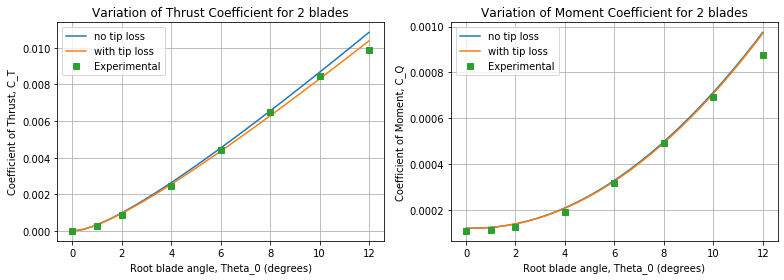

In [25]:
exp2x = [0,1,2,4,6,8,10,12]
exp2y = [0,0.00028,0.000873,0.00248,0.00442,0.0065,0.00847,0.0099 ]
expq2y = [0.000108,0.000111,0.000125,0.000191,0.000316,0.000494,0.000691,0.000878]

plt.subplots(2,1,figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(theta0, C_T2, label = 'no tip loss')
plt.plot(theta0, C_T_wl2, label = 'with tip loss')
plt.plot(exp2x, exp2y, 's', label = 'Experimental')
plt.legend()
plt.grid()
plt.xlabel("Root blade angle, Theta_0 (degrees)")
plt.ylabel("Coefficient of Thrust, C_T")
plt.title('Variation of Thrust Coefficient for 2 blades')


plt.subplot(1,2,2)
plt.plot(theta0, C_Q2, label = 'no tip loss')
plt.plot(theta0, C_Q_wl2, label = 'with tip loss')
plt.plot(exp2x, expq2y, 's', label = 'Experimental')
plt.legend()
plt.grid()
plt.xlabel("Root blade angle, Theta_0 (degrees)")
plt.ylabel("Coefficient of Moment, C_Q")
plt.title('Variation of Moment Coefficient for 2 blades')
plt.tight_layout()
plt.show()

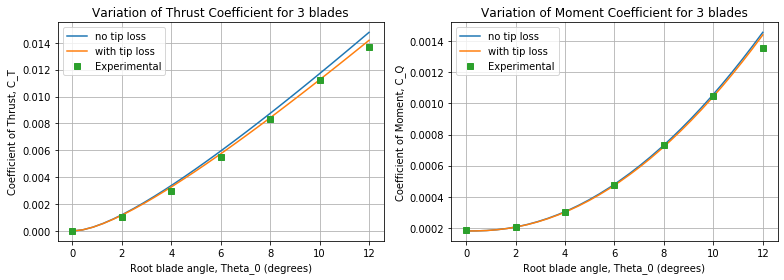

In [26]:
exp3x = [0,2,4,6,8,10,12]
exp3y = [0,0.00102,0.00298,0.00548,0.00833,0.01125,0.0137]
expq3y = [0.000185,0.000206,0.0003,0.000474,0.000735,0.001048,0.001357]

plt.subplots(2,1,figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(theta0, C_T3, label = 'no tip loss')
plt.plot(theta0, C_T_wl3, label = 'with tip loss')
plt.plot(exp3x, exp3y, 's', label = 'Experimental')
plt.legend()
plt.grid()
plt.xlabel("Root blade angle, Theta_0 (degrees)")
plt.ylabel("Coefficient of Thrust, C_T")
plt.title('Variation of Thrust Coefficient for 3 blades')

plt.subplot(1,2,2)
plt.plot(theta0, C_Q3, label = 'no tip loss')
plt.plot(theta0, C_Q_wl3, label = 'with tip loss')
plt.plot(exp3x, expq3y, 's', label = 'Experimental')
plt.legend()
plt.grid()
plt.xlabel("Root blade angle, Theta_0 (degrees)")
plt.ylabel("Coefficient of Moment, C_Q")
plt.title('Variation of Moment Coefficient for 3 blades')
plt.tight_layout()
plt.show()

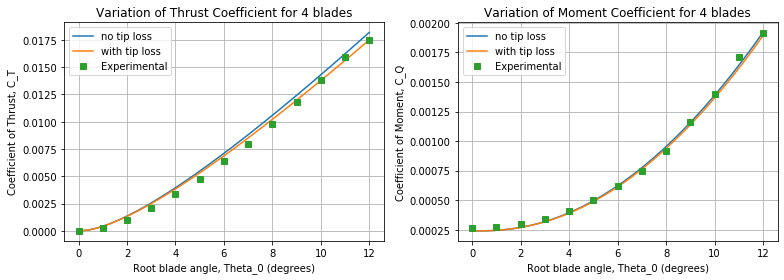

In [27]:
exp4x = [0,1,2,3,4,5,6,7,8,9,10,11,12]
exp4y = [0,0.000287,0.001042,0.00214,0.00338,0.00473,0.00645,0.00792,0.00981,0.01182,0.01382,0.01596,0.01745]
expq4y = [0.000268,0.000274,0.0003,0.000338,0.00041,0.000499,0.000620,0.000743,0.00092,0.001162,0.001395,0.00171,0.00191]

plt.subplots(2,1,figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(theta0, C_T4, label = 'no tip loss')
plt.plot(theta0, C_T_wl4, label = 'with tip loss')
plt.plot(exp4x, exp4y, 's', label = 'Experimental')
plt.legend()
plt.grid()
plt.xlabel("Root blade angle, Theta_0 (degrees)")
plt.ylabel("Coefficient of Thrust, C_T")
plt.title('Variation of Thrust Coefficient for 4 blades')

plt.subplot(1,2,2)
plt.plot(theta0, C_Q4, label = 'no tip loss')
plt.plot(theta0, C_Q_wl4, label = 'with tip loss')
plt.plot(exp4x, expq4y, 's', label = 'Experimental')
plt.legend()
plt.grid()
plt.xlabel("Root blade angle, Theta_0 (degrees)")
plt.ylabel("Coefficient of Moment, C_Q")
plt.title('Variation of Moment Coefficient for 4 blades')
plt.tight_layout()
plt.show()

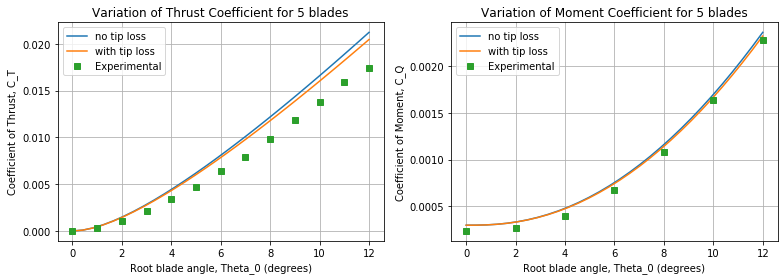

In [28]:
exp5x = [0,2,4,6,8,10,12]
exp5y = [0,0.001181,0.00362,0.00694,0.01103,0.01548,0.02]
expq5y = [0.000238,0.00027,0.000396,0.00068,0.001086,0.001635,0.00228]

plt.subplots(2,1,figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(theta0, C_T5, label = 'no tip loss')
plt.plot(theta0, C_T_wl5, label = 'with tip loss')
plt.plot(exp4x, exp4y, 's', label = 'Experimental')
plt.legend()
plt.grid()
plt.xlabel("Root blade angle, Theta_0 (degrees)")
plt.ylabel("Coefficient of Thrust, C_T")
plt.title('Variation of Thrust Coefficient for 5 blades')

plt.subplot(1,2,2)
plt.plot(theta0, C_Q5, label = 'no tip loss')
plt.plot(theta0, C_Q_wl5, label = 'with tip loss')
plt.plot(exp5x, expq5y, 's', label = 'Experimental')
plt.legend()
plt.grid()
plt.xlabel("Root blade angle, Theta_0 (degrees)")
plt.ylabel("Coefficient of Moment, C_Q")
plt.title('Variation of Moment Coefficient for 5 blades')
plt.tight_layout()
plt.show()

## Sectional Thrust 

C:\Users\Anay Panshikar\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Anay Panshikar\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


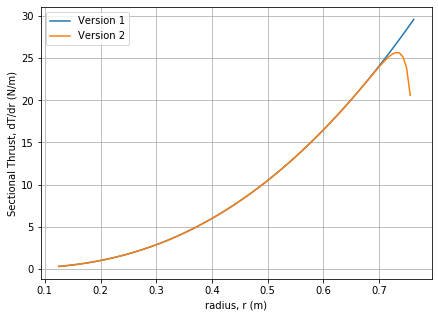

In [29]:
rad = np.linspace(r_RC,R,100)
secth1 = []
secth2 = []
for r in rad:
    secth1.append(dT(r,2,2,0, G, H, tw))
    secth2.append(dT(r,2,2,1, G, H, tw))

plt.figure(figsize=(7,5))
plt.plot(rad, secth1, label = 'Version 1')
plt.plot(rad, secth2, label = 'Version 2')
plt.legend()
plt.grid()
plt.xlabel("radius, r (m)")
plt.ylabel("Sectional Thrust, dT/dr (N/m)")
plt.show()

# Optimization for Rotor

This is done for obtaining the optimized rotors based on linear twist and linear taper for manufacturing.

In [39]:
E = 10
G = 0.025
b = 2
r_RC = 0
R = 0.2286
a = 5.75
Cd0 = 0.0113
k = 1.25
omega = 6300*2*pi/60

def optimization (tw, H, v):
# the function defined here are same as the one above, however these are just a function of the radial distance as we have 
# all the other parameters fixed.
    def theta (r):
        theta = E + tw*r
        return theta*pi/180

    def chord (r):
        c = G + H*r
        return c

    def solidity (r):
        sigma = b*chord(r) / (pi*R*R)
        return sigma
# we calculate the average solidity here, instead of taking the solidity as a function of r.
    avgs,e = i.quad(solidity, r_RC, R)

# we calculate the inflow lambda by taking into account the tip losses.
    def inflow (r):
        lambda_c = V / (omega*R)
        flow = sqrt((avgs*a/16-lambda_c/2)**2 + avgs*a/8*theta(r)*r/R) - (avgs*a/16-lambda_c/2)
        for c in range(10):
            f = b/2*(1-r/R)/flow
            F = 2/pi*acos(exp(-f))
            lamb = sqrt((avgs*a/16/F-lambda_c/2)**2 + avgs*a/8/F*theta(r)*r/R) - (avgs*a/16/F-lambda_c/2)
            flow = lamb  
        return flow

    def phi (r):
        phi = inflow(r)*R/r
        return atan(phi)

    def Cl (r):
        alpha = theta(r) - phi(r)
        return a*alpha

    def Cd (r):
        alpha = theta(r) - phi(r)
        Cd = Cd0 + k*alpha**2
        return Cd

    def velocity (r):
        U_t = omega*r
        U_p = inflow(r)*omega*R
        return sqrt(U_t**2 + U_p**2)

    def dT (r):
        dT = b*0.5*rho*velocity(r)**2*chord(r)*(Cl(r)*cos(phi(r)) - Cd(r)*sin(phi(r)))
        return dT
    
    def dP (r):
        dP = b*omega*r*0.5*rho*velocity(r)**2*chord(r)*(Cd(r)*cos(phi(r)) + Cl(r)*sin(phi(r)))
        return dP
    
    T,e1 = i.quad(dT, r_RC, R)
    P,e2 = i.quad(dP, r_RC, R)
    
    if v == 't':
        return T
    if v == 'p':
        return P

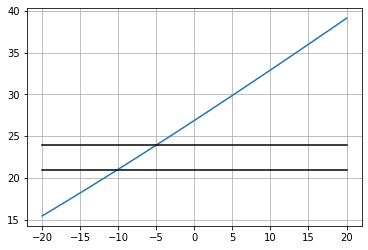

In [40]:
maxth = 24                                #max value of thrust
minth = 21                                #min value of thrust
tw = np.linspace(-20,20,200)
thtw = []
thmax = []
thmin = []
for rate in tw:
    T = optimization(rate,0,'t')
    thtw.append(T)
    thmax.append(maxth)
    thmin.append(minth)
plt.figure()
plt.grid()
plt.plot(tw,thtw)
plt.plot(tw,thmax, 'black')
plt.plot(tw,thmin, 'black')

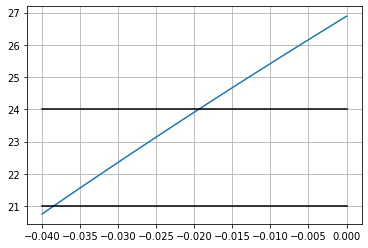

In [43]:
H = np.linspace(-0.04,0,50)
thtp = []
thmax = []
thmin = []
for rate in H:
    thtp.append(optimization(0,rate,'t'))
    thmax.append(maxth)
    thmin.append(minth)
plt.plot(H,thtp)
plt.plot(H,thmax, 'black')
plt.plot(H,thmin, 'black')
plt.grid()

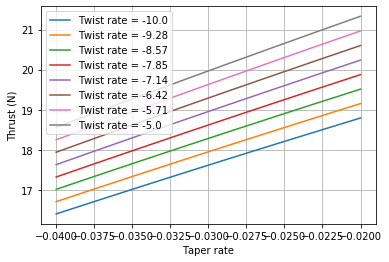

In [44]:
H = np.linspace(-0.04,-0.02,8)
twist = np.linspace(-10,-5,8)
tpmin = []

plt.figure()
plt.grid()
for twrate in twist:
    thtp = []
    for rate in H:
        T = optimization(twrate,rate,'t')
        thtp.append(T)
    plt.plot(H,thtp,label = "Twist rate = "+str(twrate)[0:5])
plt.legend()
plt.xlabel('Taper rate')
plt.ylabel('Thrust (N)')
plt.show()

In [46]:
#from the plot the value of 21N minimum thrust is obtained at 2 locations, twist = -5.71, taper = -0.02 and 
#twist = -5, taper = -0.0225
#we find power at each configuration
print(8*optimization(-5.71,-0.02,'p'))
print(8*optimization(-5.,-0.0225,'p'))

2226.5503344004064
2233.7168204833797


# Optimization for Propeller

This is done to find the power requirement of a pusher propeller for forward flight.

In [62]:
E = 10
G = 0.04
b = 2
r_RC = 0
R = 0.6
a = 5.75
Cd0 = 0.0113
k = 1.25
omega = 6000*2*pi/60
V = 22.22

def optimization (tw, H, v):
# the function defined here are same as the one above, however these are just a function of the radial distance as we have 
# all the other parameters fixed.
    def theta (r):
        theta = E + tw*r
        return theta*pi/180

    def chord (r):
        c = G + H*r
        return c

    def solidity (r):
        sigma = b*chord(r) / (pi*R*R)
        return sigma
# we calculate the average solidity here, instead of taking the solidity as a function of r.
    avgs,e = i.quad(solidity, r_RC, R)

# we calculate the inflow lambda by taking into account the tip losses.
    def inflow (r):
        lambda_c = V / (omega*R)
        flow = sqrt((avgs*a/16-lambda_c/2)**2 + avgs*a/8*theta(r)*r/R) - (avgs*a/16-lambda_c/2)
        for c in range(10):
            f = b/2*(1-r/R)/flow
            F = 2/pi*acos(exp(-f))
            lamb = sqrt((avgs*a/16/F-lambda_c/2)**2 + avgs*a/8/F*theta(r)*r/R) - (avgs*a/16/F-lambda_c/2)
            flow = lamb  
        return flow

    def phi (r):
        phi = inflow(r)*R/r
        return atan(phi)

    def Cl (r):
        alpha = theta(r) - phi(r)
        return a*alpha

    def Cd (r):
        alpha = theta(r) - phi(r)
        Cd = Cd0 + k*alpha**2
        return Cd

    def velocity (r):
        U_t = omega*r
        U_p = inflow(r)*omega*R
        return sqrt(U_t**2 + U_p**2)

    def dT (r):
        dT = b*0.5*rho*velocity(r)**2*chord(r)*(Cl(r)*cos(phi(r)) - Cd(r)*sin(phi(r)))
        return dT
    
    def dP (r):
        dP = b*omega*r*0.5*rho*velocity(r)**2*chord(r)*(Cd(r)*cos(phi(r)) + Cl(r)*sin(phi(r)))
        return dP
    
    T,e1 = i.quad(dT, r_RC, R)
    P,e2 = i.quad(dP, r_RC, R)
    
    if v == 't':
        return T
    if v == 'p':
        return P

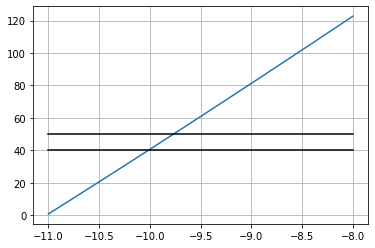

In [65]:
maxth = 50                                #max value of thrust
minth = 40                                #min value of thrust
tw = np.linspace(-11,-8,50)
thtw = []
thmax = []
thmin = []
for rate in tw:
    T = optimization(rate,0,'t')
    thtw.append(T)
    thmax.append(maxth)
    thmin.append(minth)
plt.figure()
plt.grid()
plt.plot(tw,thtw)
plt.plot(tw,thmax, 'black')
plt.plot(tw,thmin, 'black')

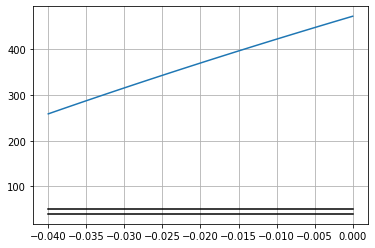

In [66]:
H = np.linspace(-0.04,0,50)
thtp = []
thmax = []
thmin = []
for rate in H:
    thtp.append(optimization(0,rate,'t'))
    thmax.append(maxth)
    thmin.append(minth)
plt.plot(H,thtp)
plt.plot(H,thmax, 'black')
plt.plot(H,thmin, 'black')
plt.grid()

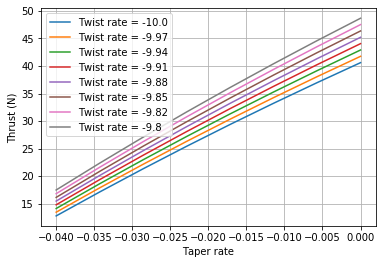

In [67]:
H = np.linspace(-0.04,0,8)
twist = np.linspace(-10,-9.8,8)
tpmin = []

plt.figure()
plt.grid()
for twrate in twist:
    thtp = []
    for rate in H:
        T = optimization(twrate,rate,'t')
        thtp.append(T)
    plt.plot(H,thtp,label = "Twist rate = "+str(twrate)[0:5])
plt.legend()
plt.xlabel('Taper rate')
plt.ylabel('Thrust (N)')
plt.show()

In [68]:
# the minimum power will be when the taper rate in minimum and twist rate maximum
print(8*optimization(-10,-0.015,'p'))

37053.56376899712
